In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def rotate(x, theta):
    mat = np.stack(([np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]), axis = 0)
    return mat@x

def grid_func(k, r):
    kr = np.sum(k[None]*r[:,:,None], axis = -1)
    g =  np.sum(np.cos(kr), axis = -1)
    return g

def grid_func_jacobian(k, r):
    kr = np.sum(k[None]*r[:,:,None], axis = -1)
    Jx = -np.sum(k[...,0]*np.sin(kr), axis = -1)
    Jy = -np.sum(k[...,1]*np.sin(kr), axis = -1)
    J = np.stack((Jx, Jy), axis = -1)
    return J

def grid_func_jacobian_det(J):
    det_j2 = np.linalg.det(np.transpose(J, (0, 2, 1))@J)
    return np.sqrt(det_j2)

def nearest_neighbour_distance(g):
    d = np.linalg.norm(g[:,None] - g[None],axis =-1)
    a = np.amax(d)
    for i in range(len(d)):
        d[i,i] = a
    return np.amin(d, axis = -1)

In [3]:
n_units = 10 # number of grids
n_waves = 2 # number of plane waves in parametrization
n_samples = 100 # number of sampled spatial points

In [4]:
box_size = 2*np.pi # size of chamber
# square wave vectors
primitive = np.array([1, 0]) # base frequency
theta = np.pi/2 # angular offset between wave vectors

k = np.array([rotate(primitive, i*theta) for i in range(n_waves)])[None]*np.ones((n_units, 1, 1))
# random phase offsets
phi = np.random.uniform(0, box_size, (n_units, 2))

#phi = np.array([ [0,0], [0, np.pi], [np.pi/2,np.pi/2]])
#phi.shape

In [5]:
x = np.linspace(0, box_size, n_samples, endpoint = False)
y = np.linspace(0, box_size, n_samples, endpoint = False)

xx, yy = np.meshgrid(x, y)
r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
rhat = r[:,None] - phi[None] # phase shift

g = grid_func(k, rhat)

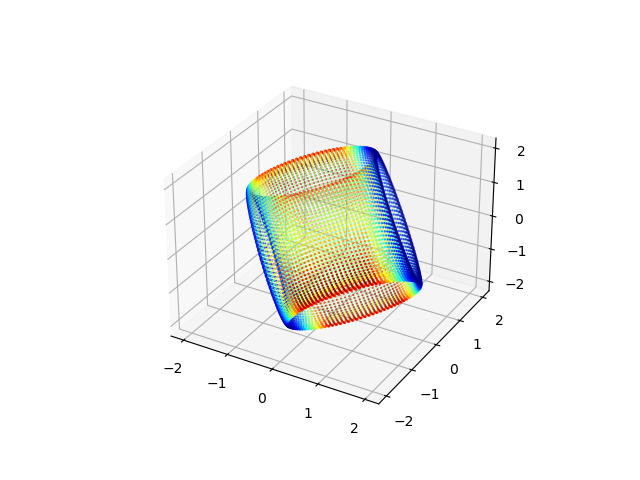

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nn = nearest_neighbour_distance(g)
ax.scatter(g[:,0], g[:,1], g[:,2], s = 0.4, c = nn, cmap = "jet")

In [7]:
# jacobian
J = grid_func_jacobian(k, rhat)
det_J = grid_func_jacobian_det(J)

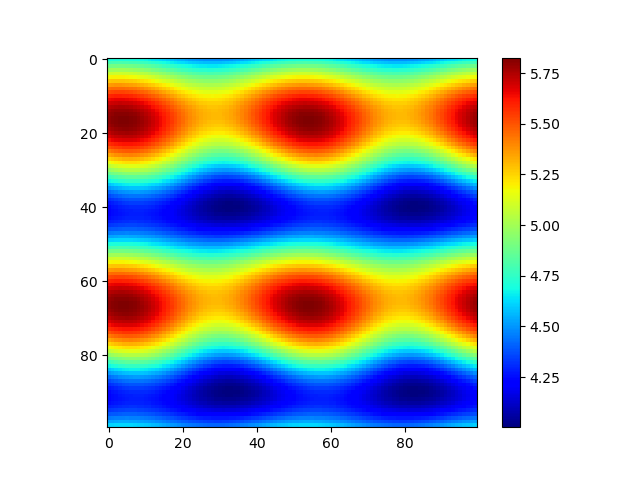

In [8]:
det_J = np.reshape(det_J, (n_samples, n_samples))
plt.figure()
plt.imshow(det_J, cmap = "jet") #visualize jacobian determinant
plt.colorbar()

## 

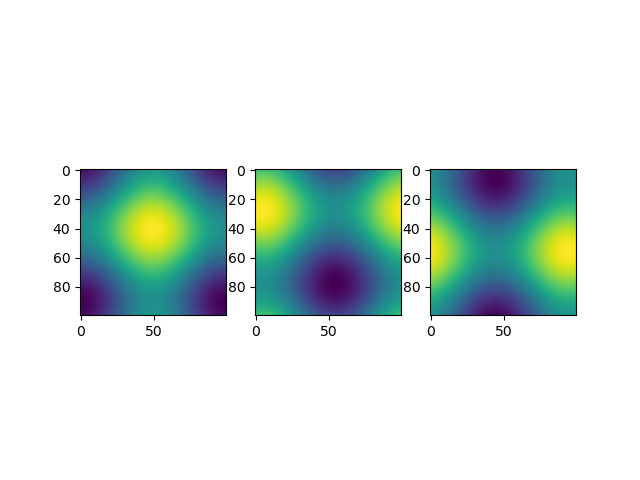

In [9]:
g = np.reshape(g, (n_samples, n_samples, -1))
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(g[...,i])
#plt.tight_layout()

In [10]:
### Sample uniformly :
umax = np.amax(det_J) # why not

In [11]:
# propose x, y from uniform distributions
# Compute corresponding value of jacobian determinant
n_samples = n_samples**2

accepted = []

while len(accepted) < n_samples:
    # sample and phase shift
    r_prop = np.random.uniform(0, box_size, (2))
    rhat = r_prop[None] - phi[None]
    J = grid_func_jacobian(k, rhat)
    det_J = grid_func_jacobian_det(J)
    
    u = np.random.uniform(0, umax)
    
    # more stretching --> higher J --> need more samples! 
    # --> increased J ---> increased acceptance probability
    if det_J > u:
        accepted.append(r_prop)

accepted = np.array(accepted)
print(f"No. accepted: {len(accepted)}.")

No. accepted: 10000.


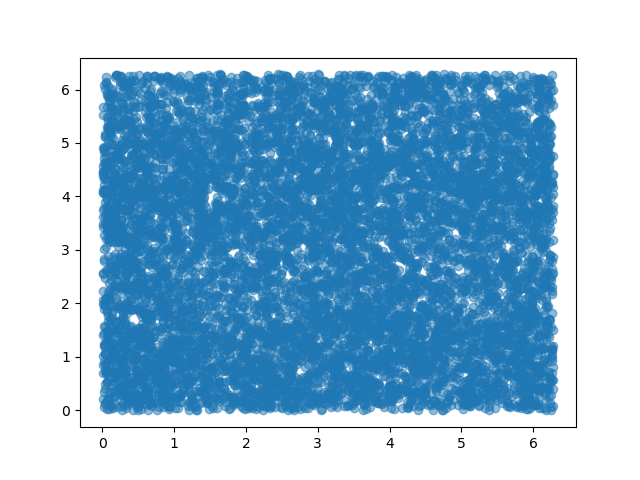

In [12]:
plt.figure()
plt.scatter(accepted[:,0], accepted[:,1], alpha = .5)
plt.show()

In [13]:
rhat = accepted[:,None] - phi[None]
uniform_g = grid_func(k, rhat)


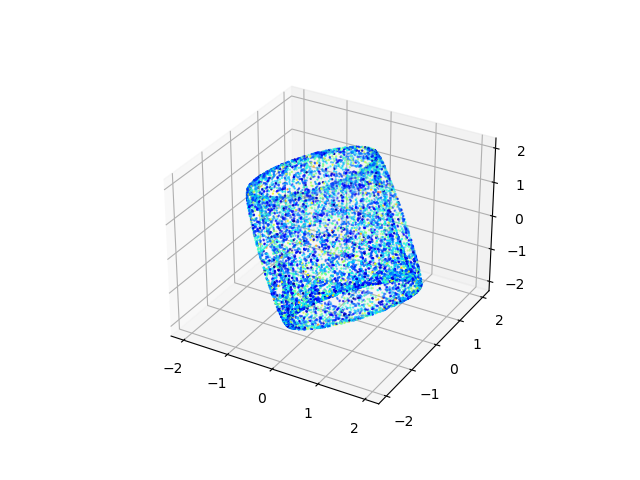

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nn = nearest_neighbour_distance(uniform_g)
ax.scatter(uniform_g[:,0], uniform_g[:,1], uniform_g[:,2], s = 0.4, c = nn,  cmap = "jet")


### Naive uniform sampling baseline

In [15]:
r_naive = np.random.uniform(0, box_size, (n_samples, 2))
rhat = r_naive[:,None] - phi[None] # phase shift
naive_g = grid_func(k, rhat)

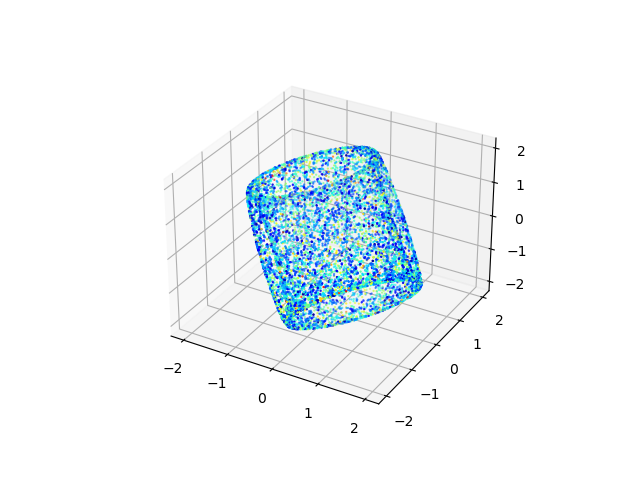

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
nn = nearest_neighbour_distance(naive_g)
ax.scatter(naive_g[:,0], naive_g[:,1], naive_g[:,2], s = 0.4, c = nn,  cmap = "jet")
